## librerias a usar



In [ ]:
import sys
import time
import numpy as np
from random import shuffle, random, sample, randint, randrange, uniform, randint
#from random import randint
#from random import permutation
from copy import deepcopy
import matplotlib.pyplot as plt

## clase Item

In [ ]:
class Item(object):
    def __init__(self, name, size):
        self.name  = name  # Valor del item. La suma de los valores de los items es lo que se quiere maximizar
        self.size = size # Peso del item. Se impone una restriccion en el peso maximo de una mochila

## Clase Individuo

In [ ]:
class individual:
    def __init__(self, chromosome):
        # Asegura que el cromosoma es una copia de la matriz de entrada
        self.chromosome = np.array(chromosome, copy=True)
        self.fitness = -1  # -1 indica que el individuo no ha sido evaluado

    def crossover_onepoint(self, other):
        """Retorna dos nuevos individuos del cruzamiento de un punto entre individuos self y other."""
        # Selecciona un punto de corte al azar en la dimensión de los ítems
        c = randrange(self.chromosome.shape[1])
        # Realiza el cruzamiento de un punto en la dimensión de los ítems
        new_chromosome1 = np.hstack((self.chromosome[:, :c], other.chromosome[:, c:]))
        new_chromosome2 = np.hstack((other.chromosome[:, :c], self.chromosome[:, c:]))
        return [individual(new_chromosome1), individual(new_chromosome2)]

    def crossover_uniform(self, other):
        """Retorna dos nuevos individuos del cruzamiento uniforme entre self y other."""
        mask = np.random.rand(*self.chromosome.shape) < 0.5
        new_chromosome1 = np.where(mask, self.chromosome, other.chromosome)
        new_chromosome2 = np.where(mask, other.chromosome, self.chromosome)
        return [individual(new_chromosome1), individual(new_chromosome2)]

    def mutation_flip(self):
        """Cambia aleatoriamente el estado de asignación de un ítem en un bin."""
        new_chromosome = deepcopy(self.chromosome)
        # Escoge un bin y un ítem al azar para mutar
        mutbin = randrange(new_chromosome.shape[0])
        mutitem = randrange(new_chromosome.shape[1])
        # Cambia el estado de asignación (de 0 a 1 o de 1 a 0)
        new_chromosome[mutbin, mutitem] = 1 - new_chromosome[mutbin, mutitem]
        return individual(new_chromosome)

    def mutation_multiflip(self, num_mutations=50):
        new_chromosome = deepcopy(self.chromosome)
        for _ in range(num_mutations):
            # Escoge un bin y un ítem al azar para mutar
            mutbin = randrange(new_chromosome.shape[0])
            mutitem = randrange(new_chromosome.shape[1])

            # Cambia el estado de asignación (de 0 a 1 o de 1 a 0)
            new_chromosome[mutbin, mutitem] = 1 - new_chromosome[mutbin, mutitem]

        return individual(new_chromosome)

## función get_fitness

In [ ]:
def get_fitness(chromosome, items, bin_size, num_bins):
    """Retorna los fitness del cromosoma pasado: suma total del tamaño de los ítems no asignados y suma total de áreas no usadas en cada bin."""
    fitness = np.zeros(2)  # 2 objetivos
    bin_usage = np.zeros(num_bins)  # Inicializa el uso de cada bin con 0

    # Calcula el uso de cada bin basado en la asignación de ítems
    for bin_index in range(num_bins):
        for item_index in range(len(items)):
            if chromosome[bin_index, item_index] == 1:  # Si el ítem está asignado a este bin
                bin_usage[bin_index] += items[item_index].size

    # Calcula la suma total de áreas no usadas en cada bin
    sum_unused_space = np.sum([bin_size - usage if usage <= bin_size else 0 for usage in bin_usage])

    # Calcula la suma total del tamaño de los ítems no asignados
    #sum_unassigned_items_size = 0
    #for item_index in range(len(items)):
    #    if np.sum(chromosome[:, item_index]) == 0:  # Si el ítem no está asignado a ningún bin
    #        sum_unassigned_items_size += items[item_index].size

    # 20240409 MMENA se corrige esta función
    sum_unassigned_items_size = 0
    for bin_index in range(num_bins):
        for item_index in range(len(items)):
            if chromosome[bin_index, item_index] == 0:  # Si el ítem está asignado a este bin
                sum_unassigned_items_size += items[item_index].size

    fitness[0] = sum_unassigned_items_size  # Minimizar la suma total del tamaño de los ítems no asignados
    fitness[1] = sum_unused_space  # Minimizar la suma total de áreas no usadas en cada bin

    # Asigna los objetivos al vector de fitness
    #if sum_unused_space != 0 and sum_unassigned_items_size!= 0 :
    #  fitness[0] = sum_unassigned_items_size  # Minimizar la suma total del tamaño de los ítems no asignados
    #  fitness[1] = sum_unused_space  # Minimizar la suma total de áreas no usadas en cada bin
    #else:
    #  fitness[0] = 0  # Minimizar la suma total del tamaño de los ítems no asignados
    #  fitness[1] = 0  # Minimizar la suma total de áreas no usadas en cada bin


    return fitness

In [ ]:
def get_fitness(chromosome, items, bin_size, num_bins):
    """Retorna los fitness del cromosoma pasado: suma total del tamaño de los ítems no asignados y suma total de áreas no usadas en cada bin."""
    fitness = np.zeros(2)  # 2 objetivos
    bin_usage = np.zeros(num_bins)  # inicializa el uso de cada bin con 0

    # Calcula el uso de cada bin basado en la asignación de ítems
    for bin_index in range(num_bins):
        for item_index in range(len(items)):
            if chromosome[bin_index, item_index] == 1:  # si el ítem está asignado a este bin
                bin_usage[bin_index] += items[item_index].size

    # Calcula la suma total de áreas no usadas en cada bin
    sum_unused_space = np.sum([bin_size - usage if usage <= bin_size else 0 for usage in bin_usage])

    # Calcula la suma total del tamaño de los ítems no asignados
    # Esta vez, asegurándonos de que cada ítem no asignado se cuente solo una vez
    sum_unassigned_items_size = sum(item.size for item_index, item in enumerate(items) if np.sum(chromosome[:, item_index]) == 0)

    fitness[0] = sum_unassigned_items_size  # Minimizar la suma total del tamaño de los ítems no asignados
    fitness[1] = sum_unused_space  # Minimizar la suma total de áreas no usadas en cada bin

    return fitness

In [ ]:
def get_fitness(chromosome, chromosome_size, items, bin_size, num_bins):
    """Retorna los fitness del cromosoma pasado: suma total del tamaño de los ítems no asignados y suma total de áreas no usadas en cada bin."""
    fitness = np.zeros(2)  # 2 objetivos
    bin_usage = np.zeros(num_bins)  # inicializa el uso de cada bin con 0
    C = bin_size*num_bins

    # Calcula el uso de cada bin basado en la asignación de ítems
    count = 0
    for bin_index in range(num_bins):
        for item_index in range(chromosome_size):
            if chromosome[bin_index, item_index] == 1:  # si el ítem está asignado a este bin
                bin_usage[bin_index] += items[count].size
            count = count+1

    # Calcula la suma total de áreas no usadas en cada bin
    sum_unused_space = np.sum([bin_size - usage if usage <= bin_size else 0 for usage in bin_usage])

    # Calcula la suma total del tamaño de los ítems no asignados
    # Esta vez, asegurándonos de que cada ítem no asignado se cuente solo una vez
    #sum_unassigned_items_size = sum(item.size for item_index, item in enumerate(items) if np.sum(chromosome[:, item_index]) == 0)
    sum_unassigned_items_size = 0
    count = 0
    count = 0
    for bin_index in range(num_bins):
      for item_index in range(chromosome_size):
        if chromosome[bin_index, item_index] == 0:
          sum_unassigned_items_size += items[count].size
        count = count+1
    fitness[0] = sum_unassigned_items_size  # Minimizar la suma total del tamaño de los ítems no asignados
    fitness[1] = sum_unused_space  # Minimizar la suma total de áreas no usadas en cada bin
    if fitness[1] != 0:
      fitness[1] = 1/sum_unused_space
    else:
      fitness[1] = 0

    return fitness



    fitness[0] = sum_unassigned_items_size  # Minimizar la suma total del tamaño de los ítems no asignados
    fitness[1] = 1/sum_unused_space  # Minimizar la suma total de áreas no usadas en cada bin

## Inicializamos la población

In [ ]:
def init_population(pop_size, chromosome_size, num_bins):
    # Inicializa una población de pop_size individuos, cada cromosoma de individuo de tamaño num_bins x chromosome_size.
    population = []
    for i in range(pop_size):
        # Crea una matriz de ceros con dimensiones num_bins x chromosome_size
        new_chromosome = np.zeros((num_bins, chromosome_size))

        # Para simplificar, asumiremos que queremos asignar aleatoriamente algunos ítems a bins en cada fila.
        # Este paso es opcional y depende de cómo quieras modelar el problema.
        for bin_index in range(num_bins):
            ones = randint(0, chromosome_size)  # Número aleatorio de ítems a asignar en este bin
            ones_indices = np.random.choice(chromosome_size, ones, replace=False)  # Índices aleatorios para asignar ítems
            new_chromosome[bin_index, ones_indices] = 1  # Asigna ítems a este bin

        # Agrega el nuevo individuo, con su cromosoma, a la población
        population.append(individual(new_chromosome))

    return population

## Evaluamos la población

In [ ]:
def evaluate_population(population, items, bin_size, num_bins,chromosome_size):
    """Evalúa una población de individuos con la función get_fitness."""
    pop_size = len(population)
    for i in range(pop_size):
        if population[i].fitness == -1:  # Evalúa solo si el individuo no está evaluado
            # Llama a get_fitness con los parámetros correctos para el problema actual
            population[i].fitness = get_fitness(population[i].chromosome, chromosome_size, items, bin_size, num_bins)

## build_offspring_population

In [ ]:
def build_offspring_population(population, crossover, mutation, pmut, num_bins):
    """Construye una población hija con los operadores de cruzamiento y mutación pasados.

    Args:
        crossover (str): Operador de cruzamiento.
        mutation (str): Operador de mutación.
        pmut (float): Tasa de mutación.
        num_bins (int): Número de bins, necesario para la mutación flip.
    """
    pop_size = len(population)

    # Selecciona parejas de individuos (mating_pool) para cruzamiento
    mating_pool = []
    for i in range(int(pop_size / 2)):
        # Escoge dos individuos diferentes aleatoriamente de la población
        permut = np.random.permutation(pop_size)
        mating_pool.append((population[permut[0]], population[permut[1]]))

    # Crea la población descendencia cruzando las parejas del mating pool
    offspring_population = []
    for i in range(len(mating_pool)):
        if crossover == "onepoint":
            offspring_population.extend(mating_pool[i][0].crossover_onepoint(mating_pool[i][1]))  # Cruzamiento 1 punto
        elif crossover == "uniform":
            offspring_population.extend(mating_pool[i][0].crossover_uniform(mating_pool[i][1]))  # Cruzamiento uniforme
        else:
            raise NotImplementedError

    # Aplica el operador de mutación con probabilidad pmut en cada hijo generado
    for i in range(len(offspring_population)):
        if uniform(0, 1) < pmut:
            if mutation == "flip":
                offspring_population[i] = offspring_population[i].mutation_flip()  # Cambia el alelo de un gen
            else:
                raise NotImplementedError

    return offspring_population

In [ ]:
def build_offspring_population(population, crossover, mutation, pmut, num_bins, num_mutations=1):
    """
    Construye una población hija con los operadores de cruzamiento y mutación pasados.

    Args:
        crossover (str): operador de cruzamiento.
        mutation (str): operador de mutación.
        pmut (float): tasa de mutación.
        num_bins (int): número de bins, necesario para la mutación flip.
        num_mutations (int): número de ítems a mutar en la mutación multiflip.
    """
    pop_size = len(population)

    # Selecciona parejas de individuos (mating_pool) para cruzamiento
    mating_pool = []
    for i in range(int(pop_size / 2)):
        # Escoge dos individuos diferentes aleatoriamente de la población
        permut = np.random.permutation(pop_size)
        mating_pool.append((population[permut[0]], population[permut[1]]))

    # Crea la población descendencia cruzando las parejas del mating pool
    offspring_population = []
    for i in range(len(mating_pool)):
        if crossover == "onepoint":
            offspring_population.extend(mating_pool[i][0].crossover_onepoint(mating_pool[i][1]))  # Cruzamiento 1 punto
        elif crossover == "uniform":
            offspring_population.extend(mating_pool[i][0].crossover_uniform(mating_pool[i][1]))  # Cruzamiento uniforme
        else:
            raise NotImplementedError

    # Aplica el operador de mutación con probabilidad pmut en cada hijo generado
    for i in range(len(offspring_population)):
        if uniform(0, 1) < pmut:
            if mutation == "flip":
                offspring_population[i] = offspring_population[i].mutation_flip()  # Cambia el alelo de un gen
            elif mutation == "multiflip":
                offspring_population[i] = offspring_population[i].mutation_multiflip(num_mutations)  # Mutación multiflip
            else:
                raise NotImplementedError

    return offspring_population

In [ ]:
def get_crowding_distances(fitnesses):
    """
    La distancia crowding de un individuo es la diferencia del fitness mas proximo hacia arriba menos el fitness mas proximo
    hacia abajo. El valor crowding total es la suma de todas las distancias crowdings para todos los fitness
    """

    pop_size = len(fitnesses[:, 0])
    num_objectives = len(fitnesses[0, :])

    # crea matriz crowding. Filas representan individuos, columnas representan objectives
    crowding_matrix = np.zeros((pop_size, num_objectives))

    # normalisa los fitnesses entre 0 y 1 (ptp es max - min)
    normalized_fitnesses = (fitnesses - fitnesses.min(0)) / fitnesses.ptp(0)

    for col in range(num_objectives):   # Por cada objective
        crowding = np.zeros(pop_size)

        # puntos extremos tienen maximo crowding
        crowding[0] = 1
        crowding[pop_size - 1] = 1

        # ordena los fitness normalizados del objectivo actual
        sorted_fitnesses = np.sort(normalized_fitnesses[:, col])
        sorted_fitnesses_index = np.argsort(normalized_fitnesses[:, col])

        # Calcula la distancia crowding de cada individuo como la diferencia de score de los vecinos
        crowding[1:pop_size - 1] = (sorted_fitnesses[2:pop_size] - sorted_fitnesses[0:pop_size - 2])

        # obtiene el ordenamiento original
        re_sort_order = np.argsort(sorted_fitnesses_index)
        sorted_crowding = crowding[re_sort_order]

        # Salva las distancias crowdingpara el objetivo que se esta iterando
        crowding_matrix[:, col] = sorted_crowding

    # Obtiene las distancias crowding finales sumando las distancias crowding de cada objetivo
    crowding_distances = np.sum(crowding_matrix, axis=1)

    return crowding_distances

In [ ]:
def select_by_crowding(population, num_individuals):
    """
    Selecciona una población de individuos basado en torneos de pares de individuos: dos individuos se escogen al azar
    y se selecciona el mejor según la distancia crowding. Se repite hasta obtener num_individuals individuos.
    """
    # Realiza una copia profunda de la población para evitar modificar la original
    population = deepcopy(population)
    pop_size = len(population)

    # Asume que el atributo fitness de cada individuo ya es una lista o tupla de valores de fitness
    num_objectives = len(population[0].fitness)

    # Extrae los fitness de la población en la matriz fitnesses
    fitnesses = np.zeros([pop_size, num_objectives])
    for i in range(pop_size):
        fitnesses[i, :] = population[i].fitness

    # Obtiene las distancias crowding
    crowding_distances = get_crowding_distances(fitnesses)

    population_selected = []  # Población escogida

    while len(population_selected) < num_individuals:
        # Escoge dos individuos aleatoriamente de la población no escogida aún
        permut = np.random.permutation(len(population))
        ind1_id = permut[0]
        ind2_id = permut[1]

        # Si ind1_id es el mejor (mayor distancia de crowding)
        if crowding_distances[ind1_id] >= crowding_distances[ind2_id]:
            # Traslada el individuo ind1 de population a la lista de individuos seleccionados
            population_selected.append(population.pop(ind1_id))
            # Remueve la distancia crowding del individuo seleccionado
            crowding_distances = np.delete(crowding_distances, ind1_id, axis=0)
        else:  # Si ind2_id es el mejor
            # Traslada el individuo ind2 de population a la lista de individuos seleccionados
            population_selected.append(population.pop(ind2_id))
            # Remueve la distancia crowding del individuo seleccionado
            crowding_distances = np.delete(crowding_distances, ind2_id, axis=0)

    return population_selected

## frontera de pareto

In [ ]:
def get_paretofront_population(population):
    """
    Obtiene de population la población de individuos de la frontera de Pareto.
    """
    population = deepcopy(population)
    pop_size = len(population)

    # Todos los individuos son inicialmente asumidos como la frontera de Pareto
    pareto_front = np.ones(pop_size, dtype=bool)

    for i in range(pop_size):  # Compara cada individuo contra todos los demás
        for j in range(pop_size):
            if i != j:
                # Chequea si individuo 'i' es dominado por individuo 'j'
                if all(np.asarray(population[j].fitness) >= np.asarray(population[i].fitness)) and any(np.asarray(population[j].fitness) > np.asarray(population[i].fitness)):
                    # j domina a i -> señaliza que individuo 'i' como no siendo parte de la frontera de Pareto
                    pareto_front[i] = False
                    break  # Para la búsqueda para 'i' (no es necesario hacer más comparaciones)

    paretofront_population = []
    for i in range(pop_size):  # Construye la lista de individuos de la frontera de Pareto
        if pareto_front[i]:
            paretofront_population.append(population[i])

    return paretofront_population

## build_next_population

In [ ]:
def build_next_population(population, min_pop_size, max_pop_size):
    """
    Construye la población de la siguiente generación añadiendo sucesivas fronteras de Pareto hasta
    tener una población de al menos min_pop_size individuos. Reduce la frontera de Pareto con el método de
    crowding distance si al agregar la frontera excede el tamaño máximo de la población (max_pop_size).
    """
    population = deepcopy(population)
    next_population = []

    while len(next_population) < min_pop_size:  # Mientras la población no tenga el tamaño mínimo
        # Obtiene la población frontera de Pareto actual
        paretofront_population = get_paretofront_population(population)

        # Si población actual + paretofront excede el máximo permitido -> reduce paretofront con el método de crowding
        combined_population_size = len(next_population) + len(paretofront_population)
        if combined_population_size > max_pop_size:
            paretofront_population = select_by_crowding(paretofront_population, max_pop_size - len(next_population))

        # Adiciona la frontera de Pareto (original o reducida) a la población en construcción
        next_population.extend(paretofront_population)

        # Remueve de population los individuos que fueron agregados a next_population
        population = [ind for ind in population if ind not in paretofront_population]

    return next_population

## función que permite sumar las cantidad de items asignados, no asignados y el total de cada uno de ellos

In [ ]:
def sumar_tamaños_por_fila(items, matriz,plocal,pglobal):
  sumatotal_asignados = 0
  sumatotal_no_asignados = 0
  num_col,num_fil = matriz.shape
  count = 0
  for bin_index in range(num_col):
    suma_asignados=0
    suma_no_asignados=0
    for item_index in range(num_fil):
      if matriz[bin_index, item_index] == 1:
        suma_asignados += items[count].size
      if matriz[bin_index, item_index] == 0:  # Si el ítem está asignado a este bin
        suma_no_asignados += items[count].size
      count = count+1
    if  plocal == 1:
      print(f"Suma de asignados: {suma_asignados}, Suma de no asignados: {suma_no_asignados}")
    sumatotal_asignados += suma_asignados
    sumatotal_no_asignados += suma_no_asignados
  if  pglobal == 1:
    print(f"Suma total de asignados: {sumatotal_asignados}, Suma total de no asignados: {sumatotal_no_asignados}")
  return   [suma_asignados,suma_no_asignados,sumatotal_asignados, sumatotal_no_asignados]

## Algoritmo genetico multiobjetivo (NSGA-II) principal

In [ ]:
# Hiperparámetros del algoritmo genético
num_items = 54          # Número de ítems
max_item_size = 50    # Máximo tamaño posible de cada ítem
num_bins = 5           # Número de bins disponibles
bin_size = 100        # Tamaño máximo que puede soportar cada bin

# Pool de ítems generado aleatoriamente
itempool = [Item(randint(1,num_bins),randint(1, max_item_size)) for _ in range(num_items)]
itemsize = [itempool[i].size for i in range (len(itempool))]

# Parámetros de la población
pop_size = 200
min_pop_size = 200
max_pop_size = 200
# El tamaño del cromosoma se define por el número de bins y el número de ítems, formando una matriz
chromosome_size = num_items // num_bins #(num_bins, num_items)
generations = 300     # Número de generaciones
pmut = 1            # Tasa de mutación
numcrom = 0
print('Número de items:', num_items)
print('Max. tamaño item:', max_item_size)
print('Items (tamaño):', itemsize)
print('Tamaño de Cromosoma:', chromosome_size)

Número de items: 54
Max. tamaño item: 50
Items (tamaño): [25, 21, 1, 12, 29, 11, 33, 23, 47, 3, 11, 5, 37, 9, 45, 32, 9, 10, 38, 14, 11, 15, 45, 20, 31, 7, 34, 18, 7, 31, 20, 40, 28, 49, 1, 9, 49, 3, 34, 13, 17, 4, 21, 46, 37, 11, 9, 50, 10, 29, 48, 37, 20, 8]
Tamaño de Cromosoma: 10


In [ ]:
# Revisión de los componentes de la variable itempool
for idx, itm in enumerate(itempool):
    print(f"Ítem {idx+1}: Nombre = {itm.name}, Tamaño = {itm.size}")

In [ ]:
# Crea una población inicial
poblacion_inicial = init_population(pop_size, chromosome_size, num_bins)

In [ ]:
print(itempool[2].size)
print(poblacion_inicial[numcrom].fitness)
print(poblacion_inicial[numcrom].chromosome)
#sumatotal= sumar_tamaños_por_fila(itempool, poblacion_inicial[numcrom].chromosome)

1
-1
[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 0. 1. 0. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [ ]:
# Llamada a la función
for i in range(2):
  sumatotal= sumar_tamaños_por_fila(itempool, poblacion_inicial[i].chromosome,plocal=0,pglobal=0)
  print(sumatotal)

[234, 0, 732, 382]
[130, 104, 542, 572]


In [ ]:
# Copia la población inicial en una nueva variable para no alterar la población inicial
p = deepcopy(poblacion_inicial)

# Evalúa la población inicial
evaluate_population(p, itempool, bin_size, num_bins,chromosome_size)

In [ ]:
# Llamada a la función
for i in range(len(p)):
  sumatotal= sumar_tamaños_por_fila(itempool, p[i].chromosome,plocal=0,pglobal=0)
  print(sumatotal)

In [ ]:
print(p[numcrom].fitness)
print(p[numcrom].chromosome)

[3.8200000e+02 9.9009901e-03]
[[0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 0. 1. 0. 0. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [ ]:
# Ejecuta los ciclos evolutivos
for g in range(generations):  # Por cada generación
    if g % 10 == 0:
        print('Generación {} (de {})'.format(g, generations))

    # Genera y evalúa la población hija
    q = build_offspring_population(p, "onepoint", "multiflip", pmut, num_bins)
    evaluate_population(q, itempool, bin_size, num_bins,chromosome_size)

    # Une la población padre y la población hija
    p.extend(q)

    # Construye la población de la siguiente generación
    p = build_next_population(p, min_pop_size, max_pop_size)

# Obtiene la población de la frontera de Pareto final
pareto_front_population = get_paretofront_population(p)

Generación 0 (de 300)
Generación 10 (de 300)
Generación 20 (de 300)
Generación 30 (de 300)
Generación 40 (de 300)
Generación 50 (de 300)
Generación 60 (de 300)
Generación 70 (de 300)
Generación 80 (de 300)
Generación 90 (de 300)
Generación 100 (de 300)
Generación 110 (de 300)
Generación 120 (de 300)
Generación 130 (de 300)
Generación 140 (de 300)
Generación 150 (de 300)
Generación 160 (de 300)
Generación 170 (de 300)
Generación 180 (de 300)
Generación 190 (de 300)
Generación 200 (de 300)
Generación 210 (de 300)
Generación 220 (de 300)
Generación 230 (de 300)
Generación 240 (de 300)
Generación 250 (de 300)
Generación 260 (de 300)
Generación 270 (de 300)
Generación 280 (de 300)
Generación 290 (de 300)


In [ ]:
print(q[numcrom].fitness)
print(q[numcrom].chromosome)

[8.76000000e+02 3.81679389e-03]
[[0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [1. 1. 0. 1. 1. 0. 1. 1. 0. 0.]
 [1. 1. 1. 0. 0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 0. 1. 0. 0. 0. 0.]]


## Diagrama de Pareto

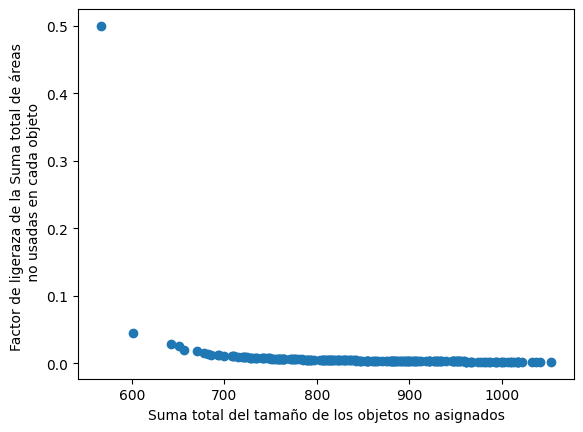

In [ ]:
## Plotea los individuos de la frontera de Pareto final
pop_size = len(pareto_front_population)
num_objectives = len(pareto_front_population[0].fitness)

# extrae los fitness de la poblacion en la matriz fitnesses
fitnesses = np.zeros([pop_size, num_objectives])
for i in range(pop_size): fitnesses[i,:] = pareto_front_population[i].fitness

x = fitnesses[:, 0]
y = fitnesses[:, 1]

plt.xlabel('Suma total del tamaño de los objetos no asignados')
plt.ylabel('Factor de ligeraza de la Suma total de áreas \n no usadas en cada objeto')
plt.scatter(x,y)
#plt.savefig('pareto.png')
plt.show()

In [ ]:
#Algunos de los valores del pareto front y su fitness:
for i in range(5):
    b = pareto_front_population[i].fitness
    print(b)

[9.06000000e+02 3.42465753e-03]
[8.8500000e+02 3.6900369e-03]
[9.0000000e+02 3.4965035e-03]
[8.94000000e+02 3.57142857e-03]
[9.0000000e+02 3.4965035e-03]


In [ ]:
#Imprime 5 soluciones de la frontera:
for i in range(5):
    a = pareto_front_population[i].chromosome
    print(a)

In [ ]:
sumatotal= sumar_tamaños_por_fila(itempool, pareto_front_population[144].chromosome,plocal=1,pglobal=1)
pareto_front_population[144].chromosome

Suma de asignados: 88, Suma de no asignados: 117
Suma de asignados: 67, Suma de no asignados: 143
Suma de asignados: 78, Suma de no asignados: 141
Suma de asignados: 62, Suma de no asignados: 184
Suma de asignados: 25, Suma de no asignados: 209
Suma total de asignados: 320, Suma total de no asignados: 794


array([[1., 0., 1., 0., 1., 0., 1., 0., 0., 0.],
       [1., 1., 0., 1., 0., 1., 0., 1., 0., 0.],
       [0., 1., 1., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
       [0., 1., 1., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
# Llamada a la función
sum02 = np.zeros(len(pareto_front_population))
sum03 = np.zeros(len(pareto_front_population))
for i in range(len(pareto_front_population)):
  sumatotal= sumar_tamaños_por_fila(itempool, pareto_front_population[i].chromosome,plocal=0,pglobal=0)
  sum02[i] = sumatotal[2]
  sum03[i] = sumatotal[3]
  if sumatotal[2] > 440 and sumatotal[2] < 501 :
    print(sumatotal)
    print(pareto_front_population[i].chromosome)
    print(i)

[98, 136, 444, 670]
[[0. 0. 0. 1. 0. 0. 1. 1. 0. 1.]
 [1. 0. 0. 1. 1. 0. 1. 1. 0. 0.]
 [0. 1. 0. 1. 1. 0. 1. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0. 0. 0. 1.]
 [1. 1. 0. 0. 1. 1. 0. 0. 0. 1.]]
25
[94, 140, 458, 656]
[[1. 0. 0. 1. 0. 0. 1. 1. 0. 1.]
 [0. 1. 0. 1. 1. 0. 1. 0. 0. 0.]
 [1. 1. 0. 0. 1. 0. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0. 0.]]
59
[87, 147, 463, 651]
[[1. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 1. 0. 1. 1. 1. 0. 1. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 1. 0. 1.]
 [0. 0. 1. 0. 0. 0. 1. 1. 0. 1.]
 [0. 1. 0. 1. 1. 0. 0. 0. 0. 0.]]
66
[94, 140, 472, 642]
[[1. 1. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 1. 1. 0. 1. 0. 1. 0.]
 [0. 1. 0. 0. 1. 0. 1. 0. 1. 0.]
 [0. 0. 1. 1. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0. 0.]]
170


Text(0, 0.5, 'Valor')

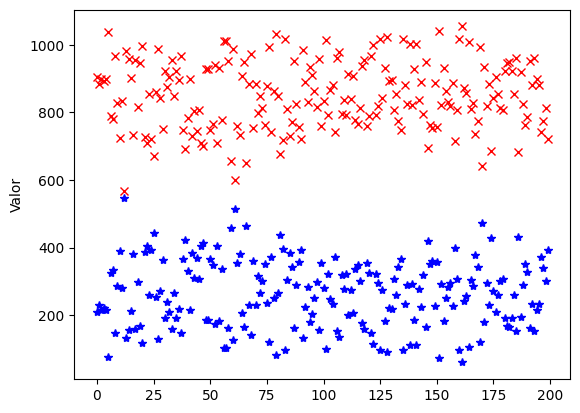

In [ ]:
plt.plot(sum02,"*", color='blue')
plt.plot(sum03,"x", color='red')
#plt.xlabel('S')
plt.ylabel('Valor')

In [ ]:
sumar_tamaños_por_fila(itempool, pareto_front_population[59].chromosome,plocal=1,pglobal=1)

Suma de asignados: 96, Suma de no asignados: 109
Suma de asignados: 68, Suma de no asignados: 142
Suma de asignados: 109, Suma de no asignados: 110
Suma de asignados: 91, Suma de no asignados: 155
Suma de asignados: 94, Suma de no asignados: 140
Suma total de asignados: 458, Suma total de no asignados: 656


[94, 140, 458, 656]

## final

In [ ]:
len(pareto_front_population)

200